In [ ]:
pip install numpy matplotlib opencv-python


Epoch 1 - Loss: 0.5967, Train Acc: 0.7804, Test Acc: 0.7967
Epoch 2 - Loss: 0.4828, Train Acc: 0.8266, Test Acc: 0.8486
Epoch 3 - Loss: 0.4490, Train Acc: 0.8395, Test Acc: 0.8471
Epoch 4 - Loss: 0.4273, Train Acc: 0.8455, Test Acc: 0.8490
Epoch 5 - Loss: 0.4086, Train Acc: 0.8526, Test Acc: 0.8539

Final Evaluation on Test Data:
Accuracy:  85.39%
Precision: 86.59%
Recall:    85.33%
F1-score:  85.44%


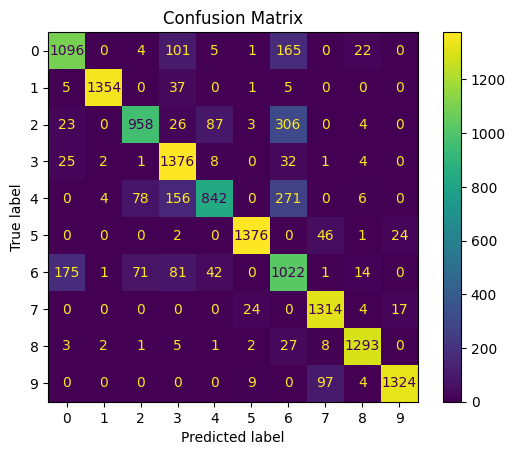

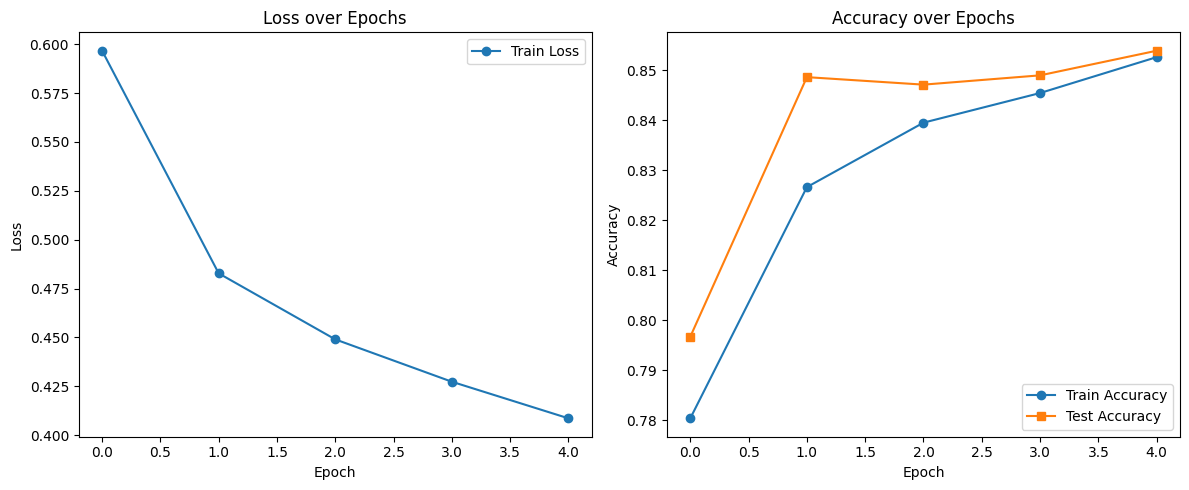

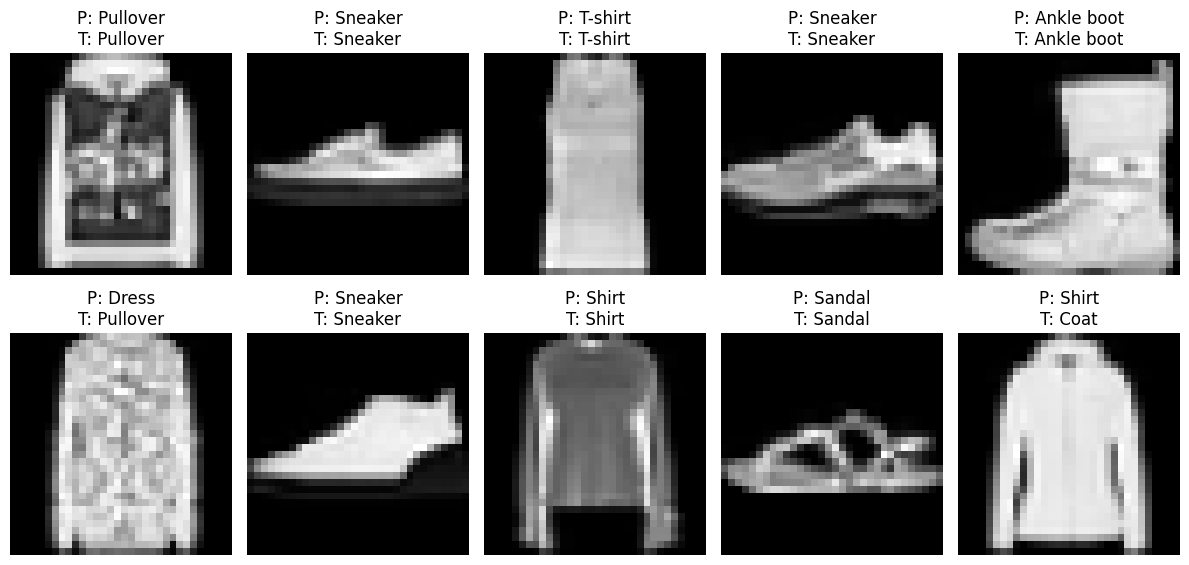

In [ ]:
import numpy as np
import gzip
import urllib.request
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Download and load Fashion-MNIST
def load_fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz'
    }
    data = {}
    for key, filename in files.items():
        urllib.request.urlretrieve(base_url + filename, filename)
        with gzip.open(filename, 'rb') as f:
            if 'images' in key:
                f.read(16)
                data[key] = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, 28, 28)
            else:
                f.read(8)
                data[key] = np.frombuffer(f.read(), dtype=np.uint8)
    images = np.concatenate([data['train_images'], data['test_images']])
    labels = np.concatenate([data['train_labels'], data['test_labels']])
    return images, labels

# Preprocess images: resize to 32x32 and normalize
def preprocess_images(images, target_size=(32, 32)):
    processed = []
    for img in images:
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        img_normalized = img_resized / 255.0
        img_3ch = np.stack([img_normalized] * 3, axis=0)
        processed.append(img_3ch)
    return np.array(processed)

# One-hot encoding
def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

# AlexNet-like model
class TrackableAlexNet:
    def __init__(self):
        self.init_weights()
        self.train_loss = []
        self.train_accuracy = []
        self.test_accuracy = []

    def init_weights(self):
        self.fc1_w = np.random.randn(128, 3 * 32 * 32) * 0.01
        self.fc1_b = np.zeros(128)
        self.fc2_w = np.random.randn(10, 128) * 0.01
        self.fc2_b = np.zeros(10)

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

    def forward(self, x):
        self.x_flat = x.reshape(-1)
        self.z1 = self.fc1_w @ self.x_flat + self.fc1_b
        self.a1 = self.relu(self.z1)
        self.z2 = self.fc2_w @ self.a1 + self.fc2_b
        self.out = self.softmax(self.z2)
        return self.out

    def compute_loss(self, y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred + 1e-8))

    def backward(self, y_true, lr=0.01):
        y_pred = self.out
        dz2 = y_pred - y_true
        dw2 = np.outer(dz2, self.a1)
        db2 = dz2

        da1 = self.fc2_w.T @ dz2
        dz1 = da1 * (self.z1 > 0)
        dw1 = np.outer(dz1, self.x_flat)
        db1 = dz1

        self.fc2_w -= lr * dw2
        self.fc2_b -= lr * db2
        self.fc1_w -= lr * dw1
        self.fc1_b -= lr * db1

    def evaluate(self, x_data, y_data):
        correct = 0
        for i in range(len(x_data)):
            pred = np.argmax(self.forward(x_data[i]))
            true = np.argmax(y_data[i])
            if pred == true:
                correct += 1
        return correct / len(x_data)

    def train(self, train_x, train_y, test_x, test_y, epochs=5, lr=0.01):
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for i in range(len(train_x)):
                x, y = train_x[i], train_y[i]
                output = self.forward(x)
                total_loss += self.compute_loss(output, y)
                if np.argmax(output) == np.argmax(y):
                    correct += 1
                self.backward(y, lr)
            avg_loss = total_loss / len(train_x)
            acc = correct / len(train_x)
            self.train_loss.append(avg_loss)
            self.train_accuracy.append(acc)
            self.test_accuracy.append(self.evaluate(test_x, test_y))
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {acc:.4f}, Test Acc: {self.test_accuracy[-1]:.4f}")

# Load and preprocess data
images, labels = load_fashion_mnist()
images = preprocess_images(images)
labels_one_hot = one_hot(labels)

# Train-test split
train_x, test_x, train_y, test_y = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
train_y_labels = np.argmax(train_y, axis=1)
test_y_labels = np.argmax(test_y, axis=1)

# Train model
model = TrackableAlexNet()
model.train(train_x, train_y, test_x, test_y, epochs=5)

# Predictions
predictions = [np.argmax(model.forward(x)) for x in test_x]

# Evaluation Metrics
acc = accuracy_score(test_y_labels, predictions)
prec = precision_score(test_y_labels, predictions, average='macro')
rec = recall_score(test_y_labels, predictions, average='macro')
f1 = f1_score(test_y_labels, predictions, average='macro')

print(f"\nFinal Evaluation on Test Data:")
print(f"Accuracy:  {acc * 100:.2f}%")
print(f"Precision: {prec * 100:.2f}%")
print(f"Recall:    {rec * 100:.2f}%")
print(f"F1-score:  {f1 * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_y_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

# Plot Loss and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(model.train_loss, label="Train Loss", marker='o')
ax[0].set_title("Loss over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(model.train_accuracy, label="Train Accuracy", marker='o')
ax[1].plot(model.test_accuracy, label="Test Accuracy", marker='s')
ax[1].set_title("Accuracy over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.tight_layout()
plt.show()

# Display predictions
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_x[i][0], cmap="gray")
    pred_label = class_names[predictions[i]]
    true_label = class_names[test_y_labels[i]]
    ax.set_title(f"P: {pred_label}\nT: {true_label}")
    ax.axis("off")
plt.tight_layout()
plt.show()


Epoch 1 - Loss: 0.6663, Train Acc: 0.7622, Test Acc: 0.8281
Epoch 2 - Loss: 0.4550, Train Acc: 0.8391, Test Acc: 0.8483
Epoch 3 - Loss: 0.4090, Train Acc: 0.8543, Test Acc: 0.8594
Epoch 4 - Loss: 0.3819, Train Acc: 0.8634, Test Acc: 0.8675
Epoch 5 - Loss: 0.3629, Train Acc: 0.8700, Test Acc: 0.8724
Epoch 6 - Loss: 0.3480, Train Acc: 0.8751, Test Acc: 0.8754
Epoch 7 - Loss: 0.3357, Train Acc: 0.8787, Test Acc: 0.8776
Epoch 8 - Loss: 0.3256, Train Acc: 0.8821, Test Acc: 0.8781
Epoch 9 - Loss: 0.3166, Train Acc: 0.8849, Test Acc: 0.8813
Epoch 10 - Loss: 0.3090, Train Acc: 0.8876, Test Acc: 0.8812
Epoch 11 - Loss: 0.3016, Train Acc: 0.8908, Test Acc: 0.8841
Epoch 12 - Loss: 0.2951, Train Acc: 0.8926, Test Acc: 0.8854
Epoch 13 - Loss: 0.2889, Train Acc: 0.8954, Test Acc: 0.8848
Epoch 14 - Loss: 0.2834, Train Acc: 0.8967, Test Acc: 0.8860
Epoch 15 - Loss: 0.2778, Train Acc: 0.8994, Test Acc: 0.8864

Final Evaluation on Test Data:
Accuracy:  88.64%
Precision: 89.11%
Recall:    88.62%
F1-score

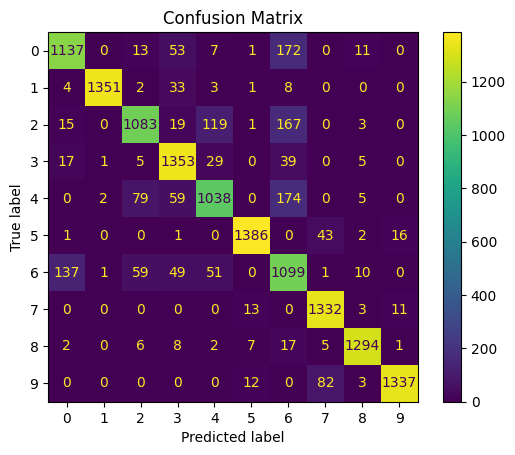

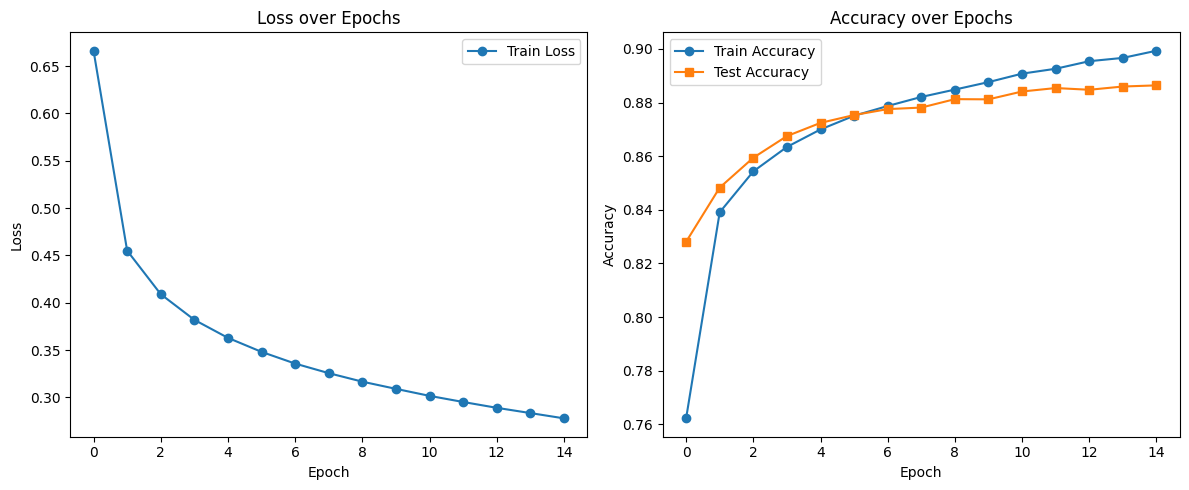

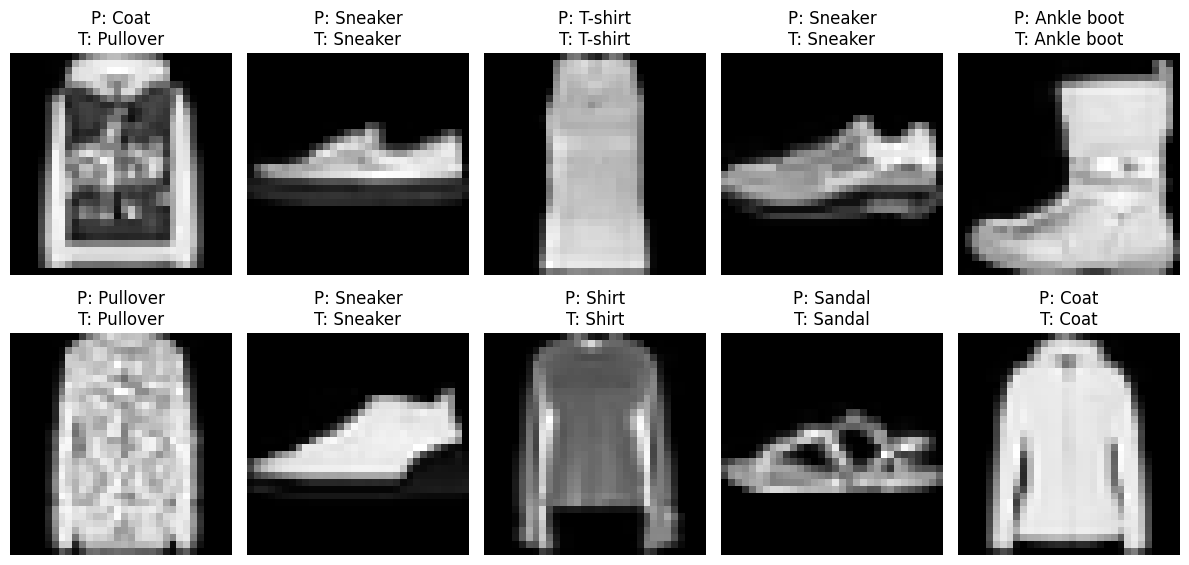

In [2]:
import numpy as np
import gzip
import urllib.request
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Download and load Fashion-MNIST
def load_fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz'
    }
    data = {}
    for key, filename in files.items():
        urllib.request.urlretrieve(base_url + filename, filename)
        with gzip.open(filename, 'rb') as f:
            if 'images' in key:
                f.read(16)
                data[key] = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, 28, 28)
            else:
                f.read(8)
                data[key] = np.frombuffer(f.read(), dtype=np.uint8)
    images = np.concatenate([data['train_images'], data['test_images']])
    labels = np.concatenate([data['train_labels'], data['test_labels']])
    return images, labels

# Preprocess images: resize to 32x32 and normalize
def preprocess_images(images, target_size=(32, 32)):
    processed = []
    for img in images:
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        img_normalized = img_resized / 255.0
        img_3ch = np.stack([img_normalized] * 3, axis=0)
        processed.append(img_3ch)
    return np.array(processed)

# One-hot encoding
def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

# AlexNet-like model
class TrackableAlexNet:
    def __init__(self):
        self.init_weights()
        self.train_loss = []
        self.train_accuracy = []
        self.test_accuracy = []

    def init_weights(self):
        self.fc1_w = np.random.randn(128, 3 * 32 * 32) * 0.01
        self.fc1_b = np.zeros(128)
        self.fc2_w = np.random.randn(10, 128) * 0.01
        self.fc2_b = np.zeros(10)

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

    def forward(self, x):
        self.x_flat = x.reshape(-1)
        self.z1 = self.fc1_w @ self.x_flat + self.fc1_b
        self.a1 = self.relu(self.z1)
        self.z2 = self.fc2_w @ self.a1 + self.fc2_b
        self.out = self.softmax(self.z2)
        return self.out

    def compute_loss(self, y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred + 1e-8))

    def backward(self, y_true, lr=0.01):
        y_pred = self.out
        dz2 = y_pred - y_true
        dw2 = np.outer(dz2, self.a1)
        db2 = dz2

        da1 = self.fc2_w.T @ dz2
        dz1 = da1 * (self.z1 > 0)
        dw1 = np.outer(dz1, self.x_flat)
        db1 = dz1

        self.fc2_w -= lr * dw2
        self.fc2_b -= lr * db2
        self.fc1_w -= lr * dw1
        self.fc1_b -= lr * db1

    def evaluate(self, x_data, y_data):
        correct = 0
        for i in range(len(x_data)):
            pred = np.argmax(self.forward(x_data[i]))
            true = np.argmax(y_data[i])
            if pred == true:
                correct += 1
        return correct / len(x_data)

    def train(self, train_x, train_y, test_x, test_y, epochs=15, lr=0.001):
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for i in range(len(train_x)):
                x, y = train_x[i], train_y[i]
                output = self.forward(x)
                total_loss += self.compute_loss(output, y)
                if np.argmax(output) == np.argmax(y):
                    correct += 1
                self.backward(y, lr)
            avg_loss = total_loss / len(train_x)
            acc = correct / len(train_x)
            self.train_loss.append(avg_loss)
            self.train_accuracy.append(acc)
            self.test_accuracy.append(self.evaluate(test_x, test_y))
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {acc:.4f}, Test Acc: {self.test_accuracy[-1]:.4f}")

# Load and preprocess data
images, labels = load_fashion_mnist()
images = preprocess_images(images)
labels_one_hot = one_hot(labels)

# Train-test split
train_x, test_x, train_y, test_y = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
train_y_labels = np.argmax(train_y, axis=1)
test_y_labels = np.argmax(test_y, axis=1)

# Train model
model = TrackableAlexNet()
model.train(train_x, train_y, test_x, test_y, epochs=15)

# Predictions
predictions = [np.argmax(model.forward(x)) for x in test_x]

# Evaluation Metrics
acc = accuracy_score(test_y_labels, predictions)
prec = precision_score(test_y_labels, predictions, average='macro')
rec = recall_score(test_y_labels, predictions, average='macro')
f1 = f1_score(test_y_labels, predictions, average='macro')

print(f"\nFinal Evaluation on Test Data:")
print(f"Accuracy:  {acc * 100:.2f}%")
print(f"Precision: {prec * 100:.2f}%")
print(f"Recall:    {rec * 100:.2f}%")
print(f"F1-score:  {f1 * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_y_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

# Plot Loss and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(model.train_loss, label="Train Loss", marker='o')
ax[0].set_title("Loss over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(model.train_accuracy, label="Train Accuracy", marker='o')
ax[1].plot(model.test_accuracy, label="Test Accuracy", marker='s')
ax[1].set_title("Accuracy over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.tight_layout()
plt.show()

# Display predictions
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_x[i][0], cmap="gray")
    pred_label = class_names[predictions[i]]
    true_label = class_names[test_y_labels[i]]
    ax.set_title(f"P: {pred_label}\nT: {true_label}")
    ax.axis("off")
plt.tight_layout()
plt.show()
